<a href="https://colab.research.google.com/github/SharifBarati/-Deceptive-Opinion-Spam-Corpus-using-deep-learning-models-Public/blob/main/tripadvisor_review_using_GLOVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DECEPTIVE REVIEW CLASSIFIER

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c9afe10a610c40d3ac464b07079847d19e2e41aec75d127cbcf27049fcc9e3fe
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import wget

In [4]:
# downloading glove files in web browser
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-04-23 10:15:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-23 10:15:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-23 10:15:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
# unzipping the zip files
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [6]:
!pip install keras_metrics

In [7]:
# importing deep learning libraries
import tqdm
import keras_metrics # for recall and precision metrics
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import time
import pickle

In [8]:
#learning word embeddings on training data using Gensim library
from gensim.models import Word2Vec, KeyedVectors
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

In [10]:
#loading dataset
df=pd.read_csv('deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [11]:
df.shape

(1600, 5)

In [12]:
df['deceptive'].value_counts()

truthful     800
deceptive    800
Name: deceptive, dtype: int64

In [13]:
df['polarity'].value_counts()

positive    800
negative    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [ ]:
df['hotel'].value_counts()

intercontinental    80
hyatt               80
james               80
palmer              80
fairmont            80
monaco              80
omni                80
ambassador          80
allegro             80
swissotel           80
hardrock            80
affinia             80
hilton              80
amalfi              80
sheraton            80
conrad              80
sofitel             80
homewood            80
knickerbocker       80
talbott             80
Name: hotel, dtype: int64

In [ ]:
df['source'].value_counts()

MTurk          800
Web            400
TripAdvisor    400
Name: source, dtype: int64

### DATA PREPROCESSING AND EDA

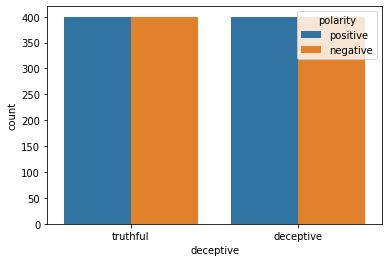

In [14]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

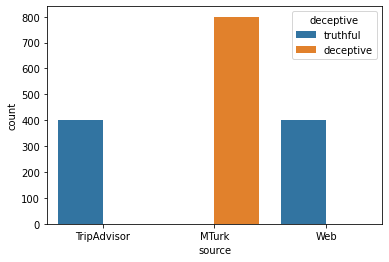

In [15]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [16]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [ ]:
# so combining three text columns --- hotel, source, text
#df['text'] = df['hotel']+' '+df['source']+' '+df['text']
#df.head()

In [17]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [18]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [19]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [20]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [21]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

,deceptive,text,clean_text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n",We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n",Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h...",This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n",The Omni Chicago really delivers on all front

In [22]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [23]:
# renaming the column
df.rename(columns = {'clean_text':'text', 'deceptive' : 'label'}, inplace = True)
df.head()

,label,text
0,1,We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level of quality the Omni delivers Check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in Chicago Even the standard room has a separate living area and work desk The fitness center has free weights weight machines and two rows of cardio equipment I shared the room with others and did not feel cramped in any way All in all a great property
4,1,I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of service but when I did they were pleasant and prompt I used the fitness center which was well equipped and everything was in working order It is in a great location at one end of the Michigan Avenue shopping district


### WORD VISUALIZATION

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [25]:
#making worldcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'on', 'o', 'for', 'once', 'ain', 'only', "didn't", 'me', 'himself', "mustn't", 'have', 'ma', 'or', 'over', 'your', 'no', 've', 'an', 'were', 'out', 'll', 'he', 'of', 'own', 'and', 'themselves', 'i', 'before', 'same', 'into', 'but', "weren't", 'being', 'whom', 'most', 'by', 'each', 'her', 'very', 'ours', "shan't", "wasn't", 'until', "you're", 'all', 'down', 'just', 'nor', 'him', 'mustn', 'such', 'while', 'where', 'below', 'who', 'in', 'is', 'here', 'doing', 'y', 'hadn', 'again', "wouldn't", 'didn', 'don', 'should', 'it', "should've", 'when', 's', 'why', "couldn't", 'then', 'shouldn', "won't", 'she', 'what', 'about', 'too', 'wouldn', 'had', 'with', 'mightn', "needn't", 'myself', 'yourself', 'can', 'them', 'ourselves', "it's", 'than', 'hers', 'the', 'through', 'a', 'further', 'they', "isn't", 'my', 'so', "you've", "you'll", 'which', 'more', "hadn't", 'any', "aren't", 'itself', 'weren', 'yours', 'did', 'couldn', "hasn't", 'our', 'd', 'this', 'up', 'be', 'isn', 'that', 'few', "shouldn't", 

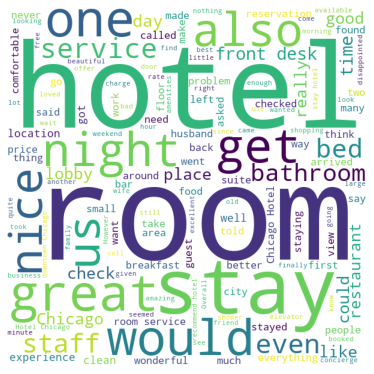

In [26]:
# visualizing the most frequent words using matplot library
comment_words = ' '
for words in df['text']: 
    comment_words = comment_words + words + ' '
    
wordcloud = WordCloud(width = 600, height = 600, 
                background_color='white' , 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### DATA PREPROCESSING -- LEMMATIZATION

In [27]:
# preprocessing the data (removing stopwords, convert the sentence to lower case, and also applying lemmatization to get meaningful words )
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnl=WordNetLemmatizer()
corpus=[]
def clean_text(review):
  review = review.lower()
  review = review.split()
  review = [wnl.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
  review = ' '.join(review)
  return review

In [28]:
df['text']=df['text'].apply(clean_text)
df.head()

,label,text
0,1,stayed one night getaway family thursday triple aaa rate steal th floor room complete plasma tv bose stereo voss evian water gorgeous bathroom concierge helpful cannot beat location flaw breakfast pricey service slow even though two table restaurant food good worth wait would return heartbeat gem chicago
1,1,triple rate upgrade view room le also included breakfast voucher great view river lake wrigley bldg tribune bldg major restaurant shopping sightseeing attraction within walking distance large room comfortable bed
2,1,come little late finally catching review past several month dear friend stayed hyatt regency late october one night visiting friend husband town hotel perfect imo easy check check lovely clean comfortable room great view city know area pretty well convenient many downtown chicago attraction dinner went clubing friend around division st problem getting cab back forth hyatt even public transportation right near bother since needed cab hotel parking usual chicago expensive able get car quickly problem best part got rate hotwire downright steal area chicago quality hotel
3,1,omni chicago really delivers front spaciousness room helpful staff prized location michigan avenue address chicago requires high level quality omni delivers check whole group people minute staff plentiful recommendation dining event room largest find price range chicago even standard room separate living area work desk fitness center free weight weight machine two row cardio equipment shared room others feel cramped way great property
4,1,asked high floor away elevator got room pleasantly decorated functional clean need whole lot service pleasant prompt used fitness center well equipped everything working order great location one end michigan avenue shopping district


### FEATURE EXTRACTION USING GLOVE

In [29]:
# assigning parameters
SEQUENCE_LENGTH = 50 # the length of all sequences (number of words per sample)
EMBEDDING_SIZE = 50  # Using 100-Dimensional GloVe embedding vectors
TEST_SIZE = 0.2 # ratio of testing set

BATCH_SIZE = 64
EPOCHS = 20 # number of epochs

# to convert labels to integers and vice-versa
label2int = {"fake": 0, "true": 1}
int2label = {0: "fake", 1: "true"}

In [30]:
# load the data
X = df['text']
y = df['label']

In [31]:
# Text tokenization
# vectorizing text, turning each text into sequence of integers
tokenizer = Tokenizer()
tokenizer

In [32]:
tokenizer.fit_on_texts(X)
# convert to sequence of integers
X = tokenizer.texts_to_sequences(X)

In [33]:
# Let's try to print the fifth sample:
print(X[5])

[11, 224, 10, 9, 1127, 46, 321, 81, 80, 3, 1, 463, 305, 7, 1426, 4, 264, 1128, 104, 157, 368, 3386, 104, 2, 742, 1641, 2192, 261, 2824, 1183, 1427, 34, 1353, 225, 1075, 3387, 53, 1, 4, 2453, 64, 440, 300, 9, 192, 1035, 20, 994, 147, 172, 44, 671, 265, 220, 2, 634, 183, 926, 10, 457, 441, 2454, 344, 511, 344, 1036, 56, 151, 304, 30, 743, 2, 4513, 3388, 168, 4514, 10, 2454, 5, 60, 1076, 113, 6, 1, 714, 224, 6, 4]


In [34]:
# convert to numpy arrays
X = np.array(X)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [35]:
X

array([list([11, 10, 9, 562, 139, 1766, 2449, 1949, 140, 1767, 196, 49, 2, 669, 925, 161, 2185, 2186, 4509, 3382, 92, 537, 30, 147, 74, 713, 763, 18, 2450, 57, 992, 7, 395, 21, 125, 41, 619, 36, 61, 26, 208, 116, 5, 232, 2451, 2187, 3]),
       list([2449, 140, 462, 33, 2, 281, 24, 498, 57, 1521, 6, 33, 293, 362, 2188, 3383, 1768, 3383, 646, 36, 124, 1123, 474, 259, 178, 240, 148, 2, 42, 12]),
       list([156, 130, 289, 105, 3384, 160, 475, 217, 484, 2819, 182, 11, 249, 490, 289, 1950, 10, 9, 367, 182, 82, 317, 1, 150, 3385, 327, 31, 31, 431, 25, 42, 2, 6, 33, 52, 166, 47, 328, 34, 439, 89, 80, 3, 474, 211, 63, 4510, 182, 100, 2189, 876, 109, 311, 432, 29, 1769, 249, 21, 844, 1033, 86, 344, 792, 189, 260, 432, 1, 197, 1124, 3, 339, 179, 15, 285, 605, 109, 69, 244, 28, 140, 1125, 2820, 1767, 47, 3, 191, 1]),
       ...,
       list([292, 3, 286, 203, 295, 1, 401, 64, 328, 286, 472, 405, 8078, 2234, 52, 297, 2, 1864, 9, 5, 138, 5, 2053, 197, 1377, 1281, 974, 1095, 485, 8079, 348, 438, 2

In [36]:
# pad sequences at the beginning of each sequence with 0's
# for example if SEQUENCE_LENGTH=4:
# [[5, 3, 2], [5, 1, 2, 3], [3, 4]]
# will be transformed to:
# [[0, 5, 3, 2], [5, 1, 2, 3], [0, 0, 3, 4]]
X = pad_sequences(X, maxlen=SEQUENCE_LENGTH)

In [37]:
X

array([[   0,    0,    0, ..., 2451, 2187,    3],
       [   0,    0,    0, ...,    2,   42,   12],
       [ 328,   34,  439, ...,    3,  191,    1],
       ...,
       [   9,    5,  138, ...,    1,   59,  399],
       [   0,    0,    0, ...,  205,   15,  726],
       [ 110,    9,   51, ..., 1120, 1850,   91]], dtype=int32)

In [38]:
# One Hot encoding labels
# [1, 0, 1, 0, 1] convert to:
# [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]]
y = to_categorical(y)

In [39]:
# We used keras.utils.to_categorial() here. Let's try to print the first sample of the labels:
print(y[0])

[0. 1.]


In [40]:
# Next, let's shuffle and split training and testing data:
# split and shuffle
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=7)

In [41]:
# Let's start by writing a function to load the pre-trained embedding vectors:
def get_embedding_vectors(tokenizer, dim=50):
    embedding_index = {}
    with open(f"glove.6B.{dim}d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [42]:
def get_model(tokenizer, lstm_units):
    """
    Constructs the model,
    Embedding vectors => LSTM => 2 output Fully-Connected neurons with softmax activation
    """
    # get the GloVe embedding vectors
    embedding_matrix = get_embedding_vectors(tokenizer)
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1,
              EMBEDDING_SIZE,
              weights=[embedding_matrix],
              trainable=False,
              input_length=SEQUENCE_LENGTH))

    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation="softmax"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
                  metrics=["accuracy", keras_metrics.precision(), keras_metrics.recall()])
    model.summary()
    return model

In [43]:
# constructs the model with 128 LSTM units
model = get_model(tokenizer=tokenizer, lstm_units=128)

Reading GloVe: 400000it [00:05, 66811.55it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            404200    
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 496,106
Trainable params: 91,906
Non-trainable params: 404,200
_________________________________________________________________


In [44]:
# print our data shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (1280, 50)
X_test.shape: (320, 50)
y_train.shape: (1280, 2)
y_test.shape: (320, 2)


In [45]:
# initialize our ModelCheckpoint and TensorBoard callbacks
# model checkpoint for saving best weights
#model_checkpoint = ModelCheckpoint("results/fakenews classifier_{val_loss:.2f}", save_best_only=True, verbose=1)
# for better visualization
#tensorboard = TensorBoard(f"logs/fakenews classifier_{time.time()}")

# train the model
model.fit(X, y,
          batch_size=BATCH_SIZE, epochs=60,
          verbose=1)

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


25/25 [==============================] - 10s 134ms/step - loss: 0.7099 - accuracy: 0.5163 - precision: 0.4900 - recall: 0.5552
Epoch 2/60
25/25 [==============================] - 3s 130ms/step - loss: 0.6709 - accuracy: 0.5925 - precision: 0.5374 - recall: 0.5655
Epoch 3/60
25/25 [==============================] - 3s 133ms/step - loss: 0.6264 - accuracy: 0.6531 - precision: 0.5682 - recall: 0.6031
Epoch 4/60
25/25 [==============================] - 3s 131ms/step - loss: 0.5982 - accuracy: 0.6794 - precision: 0.5898 - recall: 0.6415
Epoch 5/60
25/25 [==============================] - 3s 129ms/step - loss: 0.5907 - accuracy: 0.6750 - precision: 0.6081 - recall: 0.6635
Epoch 6/60
25/25 [==============================] - 3s 130ms/step - loss: 0.5542 - accuracy: 0.7169 - precision: 0.6203 - recall: 0.6797
Epoch 7/60
25/25 [==============================] - 3s 131ms/step - loss: 0.5356 - accuracy: 0.7250 - precision: 0.6331 - recall: 0.6914
Epoch 8/60
25/25 [==============================] -

In [46]:
# get the loss and metrics
result = model.evaluate(X_test, y_test)
# extract those
loss = result[0]
accuracy = result[1]
precision = result[2]
recall = result[3]

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision:   {precision*100:.2f}%")
print(f"Recall:   {recall*100:.2f}%")

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


10/10 [==============================] - 1s 19ms/step - loss: 0.0029 - accuracy: 1.0000 - precision: 0.8867 - recall: 0.8999
Accuracy: 100.00%
Precision:   88.67%
Recall:   89.99%


### MODEL EVALUATION

In [47]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=SEQUENCE_LENGTH)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector, revert using np.argmax
    return int2label[np.argmax(prediction)]

In [48]:
text = "My husband and I stayed at the Hotel Allegro in March, 2006. We had a great time! We were upgraded to a suite, and enjoyed the jacuzzi tub with Mr. Bubbles, animal print robes, and a luxurious king- sized bed! THe suite was very nice, and we had no problem with noise from other rooms or from the street. It was very boutiquey, and the lobby was lovely. We enjoyed the complementary wine hour. The staff was attentive, and our stay in this Kimpton hotel made our first-time trip to Chicago memorable! We would return here!"
print(get_predictions(text))

true


In [49]:
text = "For 250 dollars, cheapest room available at the Hard Rock Hotel Chicago, you would assume you would have access to wifi. Yet, that was not the case. I was told I 'could have had' internet if I had booked through the site, which I didnt. The lady in the reception had no idea what she was talking about and had to ask around about internet access in general."
print(get_predictions(text))

fake


In [50]:
text = "We stayed at the Conrad for 2 nights for a friends reunion. The room was clean and new feeling, nice city view, free bottled water in room upon arrival. Check in was a breeze, and our room was ready even though we were several hours early. All staff was friendly and helpful, excellent breakfast"
print(get_predictions(text))

true


In [51]:
text = "The Hard Rock Hotel in Chicago has it all: location, comfort, and rockability! We stayed at the Hard Rock Hotel in Chicago recently and found it to be amazing! The location was perfect as it is walking distance to the Magnificent Mile, Navy Pier, and Lake Michigan. It was just a short ride by bus or cab to the sports stadiums, Shedd Aquarium or the Museum of Science and Industry! The food, although it was pricey, was great! There is a spa on site if you need a little time to relax and recoup after all that rockin', and if you have pets, they get the ROYAL treatment, complete with gifts! I would highly recommend the Hard Rock Hotel of Chicago!"
print(get_predictions(text))

true


In [52]:
text = "' Barely Average Hotel at Premium Price' This hotel has a beautiful lobby but fails to fails to maintain its standards beyond the lobby. I have stayed in the Conrad in Dublin, Ireland and in HongKong both of which I loved. I was looking forward to staying at this hotel. I was extremely disappointed. I am very surprised that this hotel is allowed to carry the Conrad name. Pros: Elegant lobby nicely decorated with fresh flowers Location: Located in the Heart of Chicago Disappointments - Stained and worn out carpet in hallway - Room was small - Phone and lightbulb in room were broken - Breakfast was $60 for two people, service was slow and impolite - Hotel rationed soaps and shampoo, one bar of soap to share and one bottle of shampoo which was not replaced for two days, I felt like I was staying at a budget hotel. and to cap off my stay the hotel made a billing error which took three months and more effort than it was worth to correct. I would not stay at this hotel again, It just is not worth the premium price they charge."
print(get_predictions(text))

true


In [53]:
text = "this hotel is good and nice."
print(get_predictions(text))

fake


In [54]:
text = "this hotel is good and nice. room is very ambience and clean. staffs are very good. but i give 2 rating"
print(get_predictions(text))

fake
